# Pettijohn et al., 2016
Here, we are simulating the findings of Pettijon, et al. (2016) where the main finding was that a list of items broken up into multiple events were remembered better as a whole than an equivalent list studied in a single event

## Description of the original Experiment
Subjects were given a list of 40 words to remember while moving between four locations in physical space, divided into 4 ordered sub-lists of 10 words each. Subjects read one sub-list (10 words) then moved to a new location in space, either in a new room (shift condition) or a new space in the same room (no-shift condition) that was equated for physical distance, and read a second sub-list (10 words). Subjects were then given a distractor task, then asked to recall as many of the words as possible from both tested sub-lists.  Then the procedure was repeated with the second set of sub-lists. People were more accurate when there was a shift (main effect, ANOVA) but there was no effect of boundary X shift interaction (ANOVA, two words before and after a shift)


## Description of the simulations
Here, we generate a list of $n=20$ items $\mathbf{x} \in \mathbb{R}^d$ by drawing each as a random Gaussian vector $\mathbf{x}\sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ in high (d-)dimensional space, such that each item is approximately orthogonal. We will assume these are either encoded within a single event (simulating the no-switch condition) or in two events (simulating the switch condition) and evaluate the recall of all of the items for both conditions. 

Free recall is modeled here as the probability density of item $\mathbf{x}_i$ was in the study list $\mathbf{x}_{1:n} = \left \{\mathbf{x}_1, ..., \mathbf{x}_n \right \}$. We define the density at any moment in time in terms of the reconstruction process marginalized across time as:
\begin{equation}
    k(\mathbf{x}_i\in \mathbf{x}_{1:n}) = \sum^{n}_{t=1}k(\mathbf{x}_t = \mathbf{x}_i) p_t
    \label{eqn:recall_prob}
\end{equation}
were $p_t\propto 1$ defines the prior over time-points and $k(\mathbf{x}_t)=\Pr(\mathbf{x}_t|\tilde{\mathbf{x}})$ is a density function. 

In practice, we do not have a closed form of the densities and instead can only draw samples from the posterior distribution $\Pr (\mathbf{x} | \tilde{\mathbf{x}})$. However, we can use these samples to estimate the density function with a parametrized kernel density estimator. Let $\left <\mathbf{x}_t\right >_{1:m}$ be $m$ samples of $\mathbf{x}_t$, then a kernel density estimator $\hat{k}_{h}$ is
\begin{equation}
    \label{eqn:kde}
    \hat{k}_{h}(\mathbf{x}_t = \mathbf{x}) \equiv \frac{1}{m}\sum^{m}_{i=1}\kappa_h(\mathbf{x}-\left <\mathbf{x}_t\right >_j)
\end{equation}
where $\kappa_{h}$ is a kernel function (in our case Gaussian) parameterized by a bandwidth $h$. 

To marginalize across time, we can draw samples from the generative distribution marginalized across time, which is
\begin{equation}
    \mathbf{x} \sim \sum^{n}_{t=1}\Pr (\mathbf{x}_t = \mathbf{x}| \tilde{\mathbf{x}}_{1:n})p_t
\end{equation}
Equivalently, we can draw $m$ samples across all time points, $\left <\mathbf{x}_{1:n}\right >_{1:m}$ and treat these as $n\times m$ samples $\left <\mathbf{x}\right >_{1:nm}$. As above, we use the samples $\left <\mathbf{x}\right >_{1:nm}$ to generate a density estimate,\begin{equation}
    \hat{k}_{h}(\mathbf{x}) \equiv \frac{1}{nm}\sum^{nm}_{i=1}\kappa_h(\mathbf{x}, \left <\mathbf{x}\right >_j)
    \label{eqn:kde_maringal}
\end{equation}

For the purpose of these simulations, we only care about the average recall across all items within a condition. So, we will define accuracy as
\begin{equation}
    \text{Recall Accuracy} = \sum^{n}_{i=1}\hat k_{h}(\mathbf{x}_i)
\end{equation}
For clarity $\mathbf{x}_i$ refers to the original item vectors, and as such, recall accuracy is defined as the average density of the items evaluated on the posterior density estimate. In practice, all of the calculations use log densities (and as such, the logsumexp approximation is a potential source of error).

# Simluations

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from models import SEM, KerasSimpleRNN
from tqdm import tnrange
from sklearn.neighbors import KernelDensity
from scipy.special import logsumexp


np.random.seed(1234)
sns.set_context('paper', font_scale=1.5)

Using TensorFlow backend.


train either one or two event models on the list of words

In [2]:
N = 20
D = 25
x = np.random.randn(N, D)

# for our purposes, we need to properly encode the transition function
f_opts=dict(n_epochs=100, optimizer='adam', n_hidden1=D, n_hidden2=D,
           l2_regularization=0.0, dropout=0.00)
event_model = KerasSimpleRNN(D, **f_opts)

In [3]:
event_model.update_f0(x[0, :])
for ii in range(1, N):
    event_model.update(x[ii-1, :], x[ii, :])

# evaluate the geneartive error of the model
x_hat = event_model.run_generative(N)
print "Single Event model error", np.sum((x - x_hat)**2)

# for comparison, the generative error of an untrained model
null_model = KerasSimpleRNN(D, **f_opts)
x_hat = null_model.run_generative(N)
np.sum((x - x_hat)**2)
print "Untrained model error", np.sum((x - x_hat)**2)

Single Event model error 43.998251444023644
Untrained model error 460.39373938197934


In [4]:
# noise parameter
tau = 1.00
x_mem = x + np.random.randn(N, D) * tau

### Recontstruction  functions
Here, we define parameters of the reconstrcution common to all models

In [5]:
beta = 0.01  # Transition noise parameter (assumption)

Define a reconstruction function that assumes no event boundaries occured

In [6]:
def reconstruct_no_boundaries(x_mem, event_model, burn_in=500, n_samples=2000):
    x_samples = []

    # randomly intialize the sample of x0 from the corruption process
    x0 = np.random.randn(N, D) * tau + x_mem

    # because the beta and tau are assumed and constant, we can pre-cacluate u 
    # and lambda for the weighted mean of the posterior over x
    u = (1./beta) / (1./beta + 1./tau)  #beta and tau are global variables
    lmda = 1.0 / (1./beta + 1./tau)

    trials = range(0, N) 
    for ii in range(n_samples + burn_in):
        np.random.shuffle(trials) # randomize the order
        for t in trials:

        # pull the correct transition function
            if t > 0:
                def f(X):
                    return event_model.predict_next_generative(X)
            else:
                def f(X):
                    return event_model.predict_f0()

            # construct the input vector for the model
            x_i = x0[:t, :]

            # use the likelihood function to estimate a new sample. 
            # This likelihood function is the product of two gaussians:
            #  N(x0_t; f(x0_{1:t-1}), beta_f * I) * N(x0_t; \tilde x_t , beta_mem * I )
            mu_t = u * f(x_i) + (1 - u) * x_mem[t]

            # generate a sample from the multivariate normal
            x0[t, :] = np.random.multivariate_normal(mu_t.flatten(), lmda * np.eye(D))

        if ii >= burn_in:
            x_samples.append(x0.copy())    
    return np.array(x_samples)

Define a reconstruction function that assumes a single event boundary halfway through the study list. Here, we assume that the event dynamics are linked to the correct event (This isn't a strong assumption for only two events).

In [7]:
def reconstruct_single_boundary(x_mem, event_model_1, event_model_2, 
                                burn_in=500, n_samples=2000):    
    x_samples = []
    
    # randomly intialize the sample of x0 from the corruption process
    x0 = np.random.randn(N, D) * tau + x_mem

    # because the beta and tau are assumed and constant, we can pre-cacluate u 
    # and lambda for the weighted mean of the posterior over x
    u = (1./beta) / (1./beta + 1./tau)
    lmda = 1.0 / (1./beta + 1./tau)

    trials = range(0, N) 
    for ii in range(n_samples + burn_in):
        np.random.shuffle(trials) # randomize the order
        for t in trials:

            # pull the correct transition function
            if t < N/2:
                if t > 0:
                    def f(X):
                        return event_model_1.predict_next_generative(X)
                else:
                    def f(X):
                        return event_model_1.predict_f0()
                # construct the input vector for the model
                x_i = x0[:t, :]
            else:
                if t > N/2:
                    def f(X):
                        return event_model_2.predict_next_generative(X)
                else:
                    def f(X):
                        return event_model_2.predict_f0()
                # construct the input vector for the model
                x_i = x0[N/2:t, :]

            # use the likelihood function to estimate a new sample. 
            # This likelihood function is the product of two gaussians:
            #  N(x0_t; f(x0_{1:t-1}), beta_f * I) * N(x0_t; \tilde x_t , beta_mem * I )

            mu_t = u * f(x_i) + (1 - u) * x_mem[t]

            # generate a sample from the multivariate normal
            x0[t, :] = np.random.multivariate_normal(mu_t.flatten(), lmda * np.eye(D))

        if ii >= burn_in:
            x_samples.append(x0.copy())
                          
    return np.array(x_samples)

Define a function to generate a batch including a randomly drawn study list and the two alternatate reconstructions 

In [8]:
def batch_sample(burn_in=500, n_samples=2000):
    
    x = np.random.randn(N, D)  # generate a new sample of random scene vectors
    
    # noise parameter
    tau = 1.00
    x_mem = x + np.random.randn(N, D) * tau
    
    ############# estimate a single model for event structre
    event = KerasSimpleRNN(D, **f_opts)
    event.update_f0(x[0, :])
    for ii in range(1, N):
        event.update(x[ii-1, :], x[ii, :])
    
    trials = range(0, N) 
    beta = 0.01
    
    x_samples_1e = reconstruct_no_boundaries(x_mem, event, burn_in=burn_in, 
                                             n_samples=n_samples)

    #####################
    
    # train new event models!
    event1 = KerasSimpleRNN(D, **f_opts)
    event2 = KerasSimpleRNN(D, **f_opts)
    x_e1 = x[:10, :]
    event1.update_f0(x_e1[0, :])
    for ii in range(1, N/2):
        event1.update(x_e1[ii-1, :], x_e1[ii, :])
        
    x_e2 = x[10:, :]
    event2.update_f0(x_e2[0, :])
    for ii in range(1, N/2):
        event2.update(x_e2[ii-1, :], x_e2[ii, :])
    
    x_samples_2e = reconstruct_single_boundary(x_mem, 
                                               event_model_1=event1, 
                                               event_model_2=event2, 
                                               burn_in=burn_in, n_samples=n_samples)
            
    return {'StudyList': x, 'Sample No Boundary': x_samples_1e,
            'Sample Boundary': x_samples_2e}

In [9]:
# run the simluations

n_batch = 25
burn_in = 500
n_samples = 2000

results = {ii: batch_sample(burn_in, n_samples) for ii in tnrange(n_batch)}

HBox(children=(IntProgress(value=0, max=25), HTML(value=u'')))

In [10]:
# evaluate the recall given the reconstructed memory samples for each batch

def logsumexp_mean(x, axis=0):
    return logsumexp(x, axis=0) - np.log(np.shape(x)[axis])

hs = np.arange(0.1, 1.01, 0.05)
one_event_scores = np.zeros((n_batch, len(hs)))
two_event_scores = np.zeros((n_batch, len(hs)))

for ii, res in results.iteritems():
    ############# Generate density estimates!
    if hs is None:
        hs = np.arange(0.1, 1.0, 0.01)
        
    x = res['StudyList']
    x_s1e = res['Sample No Boundary']
    x_s2e = res['Sample Boundary']


    for jj, h in enumerate(hs):
        
        # estimate a density function for each sample and parameter
        k_1e = KernelDensity(bandwidth=h).fit(np.reshape(x_s1e, (-1, D)))
        k_2e = KernelDensity(bandwidth=h).fit(np.reshape(x_s2e, (-1, D)))

        # average the densities overall the samples (these are log densities, but 
        # we are averaging over densities) and store
        one_event_scores[ii, jj] = logsumexp_mean(k_1e.score_samples(x))
        two_event_scores[ii, jj] = logsumexp_mean(k_2e.score_samples(x))
        

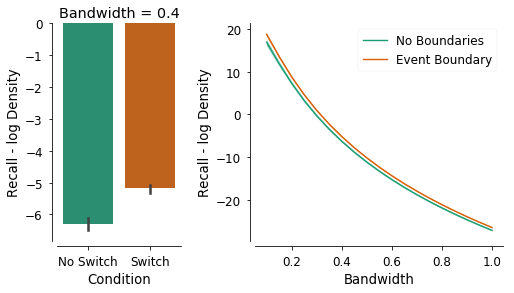

In [11]:
# plot the results!

import pandas as pd
from seaborn.algorithms import bootstrap

fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1, 2], 'wspace':0.4},
                         figsize=(8, 4))

h = 0.4

cc = sns.color_palette('Dark2')

idx = np.arange(len(hs))[(hs - h)**2 < 0.0001][0]
df = pd.concat([
    pd.DataFrame({
        'Condition': ['No Switch'] * one_event_scores.shape[0],
        'Recall - log Density': one_event_scores[:, idx]
    }),
    pd.DataFrame({
        'Condition': ['Switch'] * two_event_scores.shape[0],
        'Recall - log Density': two_event_scores[:, idx]
    })])

sns.barplot(data=df, x='Condition', y='Recall - log Density', 
            ax=axes[0], estimator=logsumexp_mean, palette=cc)
axes[0].set_title('Bandwidth = %.1f' % h)

ax = axes[1]
y = logsumexp_mean(one_event_scores)
ax.plot(hs, y, color=cc[0], label='No Boundaries')

y = logsumexp_mean(two_event_scores)
ax.plot(hs, y, color=cc[1], label='Event Boundary')

# use bootstrapping to estimate a confidence interval
boot_data = bootstrap(one_event_scores, func=logsumexp_mean)
y_er_lb, y_er_ub = sns.utils.ci(boot_data, axis=0)
ax.fill_between(hs, y_er_lb, y_er_ub, color=cc[0], alpha=0.50)

boot_data = bootstrap(two_event_scores, func=logsumexp_mean)
y_er_lb, y_er_ub = sns.utils.ci(boot_data, axis=0)
ax.fill_between(hs, y_er_lb, y_er_ub, color=cc[1], alpha=0.50)


ax.set_xlabel('Bandwidth')
ax.set_ylabel('Recall - log Density')
ax.legend()
sns.despine(offset=5)

plt.savefig('pettijohn.png', dpi=300, bbox_inches='tight')

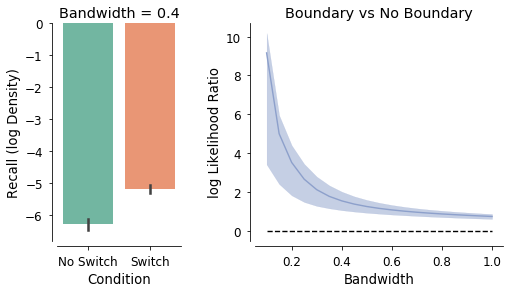

In [64]:
# plot the results!

import pandas as pd
from seaborn.algorithms import bootstrap

fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1, 2], 'wspace':0.4},
                         figsize=(8, 4))

h = 0.4

cc = sns.color_palette('Set2')

idx = np.arange(len(hs))[(hs - h)**2 < 0.0001][0]
df = pd.concat([
    pd.DataFrame({
        'Condition': ['No Switch'] * one_event_scores.shape[0],
        'Recall (log Density)': one_event_scores[:, idx]
    }),
    pd.DataFrame({
        'Condition': ['Switch'] * two_event_scores.shape[0],
        'Recall (log Density)': two_event_scores[:, idx]
    })])

sns.barplot(data=df, x='Condition', y='Recall (log Density)', 
            ax=axes[0], estimator=logsumexp_mean, palette=cc)
axes[0].set_title('Bandwidth = %.1f' % h)

ax = axes[1]
y = logsumexp_mean(two_event_scores - one_event_scores)
ax.plot(hs, y, color=cc[2],)

# use bootstrapping to estimate a confidence interval
boot_data = bootstrap(two_event_scores - one_event_scores, func=logsumexp_mean)
y_er_lb, y_er_ub = sns.utils.ci(boot_data, axis=0)
ax.fill_between(hs, y_er_lb, y_er_ub, color=cc[2], alpha=0.5)
ax.plot(hs, np.zeros(len(hs)),  'k--', )
ax.set_xlabel('Bandwidth')
ax.set_ylabel('log Likelihood Ratio')
ax.set_title('Boundary vs No Boundary')
sns.despine(offset=5)

plt.savefig('pettijohn_ratio.png', dpi=300, bbox_inches='tight')

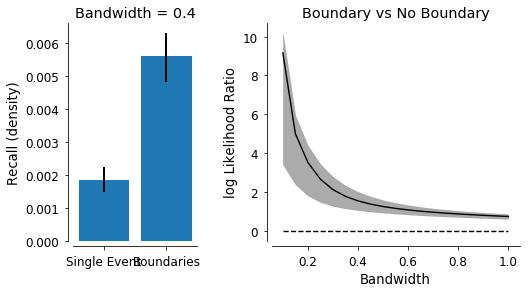

In [55]:
# plot the results!

import pandas as pd
from seaborn.algorithms import bootstrap

fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1, 2], 'wspace':0.4},
                         figsize=(8, 4))

h = 0.4

cc = sns.color_palette('Dark2')

ax = axes[0]

idx = np.arange(len(hs))[(hs - h)**2 < 0.0001][0]
y = [logsumexp_mean(one_event_scores[:, idx]), logsumexp_mean(two_event_scores[:, idx])]
ax.bar([0, 1], np.exp(y))

boot_data = bootstrap(one_event_scores[:, idx], func=logsumexp_mean)
ax.plot([0, 0], np.exp(sns.utils.ci(boot_data, axis=0)), lw=2.0, color='k')

boot_data = bootstrap(two_event_scores[:, idx], func=logsumexp_mean)
ax.plot([1, 1], np.exp(sns.utils.ci(boot_data, axis=0)), lw=2.0, color='k')

ax.set_xticks([0, 1])
ax.set_xticklabels(['Single Event', 'Boundaries'])
ax.set_ylabel('Recall (density)')
ax.set_title('Bandwidth = %.1f' % h)

ax = axes[1]
y = logsumexp_mean(two_event_scores - one_event_scores)
ax.plot(hs, y, color='k')

# use bootstrapping to estimate a confidence interval
boot_data = bootstrap(two_event_scores - one_event_scores, func=logsumexp_mean)
y_er_lb, y_er_ub = sns.utils.ci(boot_data, axis=0)
ax.fill_between(hs, y_er_lb, y_er_ub, color='k', alpha=0.33)
ax.plot(hs, np.zeros(len(hs)), 'k--')
# ax.set_yticks(range(0, 21, 5))
ax.set_xlabel('Bandwidth')
ax.set_ylabel('log Likelihood Ratio')
ax.set_title('Boundary vs No Boundary')

y_labels = np.linspace(0, 10, 2)
# ax.set_yticks(np.e**y_labels)
# ax.set_yticklabels(y_labels)
sns.despine(offset=5)

# plt.savefig('pettijohn_ratio.png', dpi=300, bbox_inches='tight')

## Why does this happen?
One possibility is that the event boundaries prevent the propogation of uncertainty by the generative process. That is, the reconstruction process transition function over uses uncertain estimates of vectors and as such, this uncertainty can be propogated to all of the estimates that are downstream. An event boundary resets this process, preventing the uncertianty of the estiamtes from one effect from increaseing the uncertainty of the other. 

In practice, we should see this with increasing error in the estimates across time within an event. Here, our measure is different than our measure of recall, because here we do care that each vector is reconstructed accurately at each moment of time. That is, we are measuring a loss function $L(\mathbf{x}_t, \hat{\mathbf{x}}_t)$ not $L(\mathbf{x}_i \in \mathbf{x}_{1:t})$

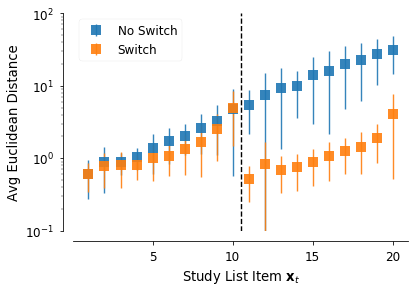

In [65]:
distances_one_event = np.zeros((n_batch, N))
distances_two_event = np.zeros((n_batch, N))

for ii, res in results.iteritems():
    ############# Generate density estimates!
    if hs is None:
        hs = np.arange(0.1, 1.0, 0.01)
        
    x = res['StudyList']
    x_s1e = res['Sample No Boundary']
    x_s2e = res['Sample Boundary']
    
    distances_one_event[ii, :] = np.mean(np.sum((x_s1e  - np.tile(x, (n_samples, 1, 1))) ** 2,
                                                axis=2), axis=0)
    distances_two_event[ii, :] = np.mean(np.sum((x_s2e  - np.tile(x, (n_samples, 1, 1))) ** 2,
                                                axis=2), axis=0)

y1 = np.mean(distances_one_event, axis=0)
y2 = np.mean(distances_two_event, axis=0)
y1_err = np.std(distances_one_event, axis=0)
y2_err = np.std(distances_two_event, axis=0)


pltKwargs = {'ls':'None', 'marker':'s', 'markersize':10, 'alpha':0.90}
plt.errorbar(range(1, N+1), y1, label='No Switch',  yerr=y1_err, **pltKwargs)
plt.errorbar(range(1, N+1), y2, label='Switch', yerr=y2_err, **pltKwargs)

plt.legend()
plt.ylabel(r'Avg Euclidean Distance')
plt.xlabel(r'Study List Item $\mathbf{x}_t$')
plt.xticks(range(0, 21, 5))

plt.plot([10.5, 10.5], [10**-1, 10**2], 'k--')
plt.ylim([10**-1, 10**2])

plt.gca().set_yscale('log')

sns.despine(offset=10)
plt.savefig('pettijohn_compounding_error.png', dpi=300, bbox_inches='tight')